# PCA

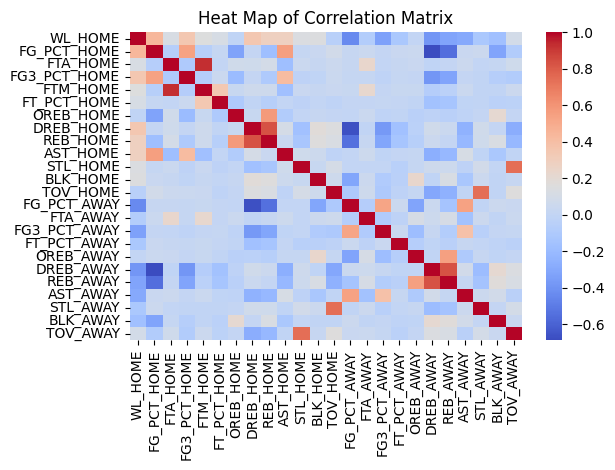

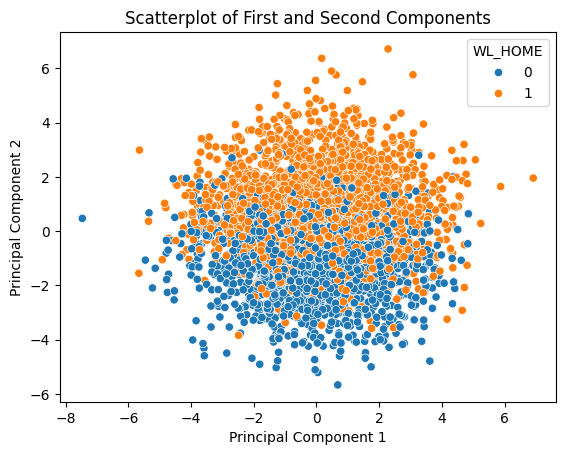

0.9258345296842831

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import randint

import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys
sys.path.append(os.getcwd() + "/helperfunctions")
from preprocfunc import OutlierTrans

pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:,.2f}'.format

# setup the features and target
nbagames = pd.read_csv("data/nbagames2017plus.csv", parse_dates=['GAME_DATE'])
nbagames = nbagames.loc[nbagames.WL_HOME.isin(['W','L'])]
nbagames.shape

nbagames['WL_HOME'] = \
  np.where(nbagames.WL_HOME=='L',0,1).astype('int')
  
nbagames.WL_HOME.value_counts(dropna=False)

nbagames.head()

# identify numeric and categorical data
num_cols = ['FG_PCT_HOME','FTA_HOME','FG3_PCT_HOME',
  'FTM_HOME','FT_PCT_HOME','OREB_HOME','DREB_HOME',
  'REB_HOME','AST_HOME','STL_HOME','BLK_HOME','TOV_HOME',
  'FG_PCT_AWAY','FTA_AWAY','FG3_PCT_AWAY',
  'FT_PCT_AWAY','OREB_AWAY','DREB_AWAY','REB_AWAY',
  'AST_AWAY','STL_AWAY','BLK_AWAY','TOV_AWAY']


nbagames[['WL_HOME'] + num_cols].agg(['count','min','median','max']).T

# look at some correlations
corrmatrix = nbagames[['WL_HOME'] + num_cols].\
  corr(method="pearson")

sns.heatmap(corrmatrix, xticklabels=corrmatrix.columns,
  yticklabels=corrmatrix.columns, cmap="coolwarm")
plt.title('Heat Map of Correlation Matrix')
plt.tight_layout()
plt.show()

# create training and testing DataFrames
X_train, X_test, y_train, y_test =  \
  train_test_split(nbagames[num_cols],\
  nbagames[['WL_HOME']], test_size=0.2, random_state=0)


# instantiate a pca object and fit the model
pca = PCA(n_components=7)

pipe1 = make_pipeline(OutlierTrans(2),
  SimpleImputer(strategy="median"), StandardScaler(), pca)

pipe1.fit(X_train)

pipe1['pca'].components_

# take a closer look at the components
components = pd.DataFrame(pipe1['pca'].components_,
  columns=num_cols).T

components.columns = ['pc1','pc2','pc3','pc4','pc5','pc6','pc7']

components.to_excel('views/components.xlsx')

components.pc1.abs().nlargest(5)
components.pc2.abs().nlargest(5)
components.pc3.abs().nlargest(5)

np.set_printoptions(precision=3)
pipe1['pca'].explained_variance_ratio_
np.cumsum(pipe1['pca'].explained_variance_ratio_)

# plot the principal components
X_train_pca = pd.DataFrame(pipe1.transform(X_train),
  columns=components.columns, index=X_train.index).\
    join(y_train, how="left", on=None, validate="many_to_many")

sns.scatterplot(x=X_train_pca.pc1, y=X_train_pca.pc2, hue=X_train_pca.WL_HOME)
plt.title("Scatterplot of First and Second Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


# do a grid search for pca followed by a logistic regression
lr = LogisticRegression()

pipe2 = make_pipeline(OutlierTrans(2),
  SimpleImputer(strategy="median"), StandardScaler(),
  pca, lr)


lr_params = {
  "pca__n_components": randint(3, 20),
  "logisticregression__C": uniform(loc=0, scale=10)
}

rs = RandomizedSearchCV(pipe2, lr_params, cv=4, 
  n_iter=40, scoring='accuracy', random_state=1)
rs.fit(X_train, y_train.values.ravel())

rs.best_params_
rs.best_score_

# 内核PCA

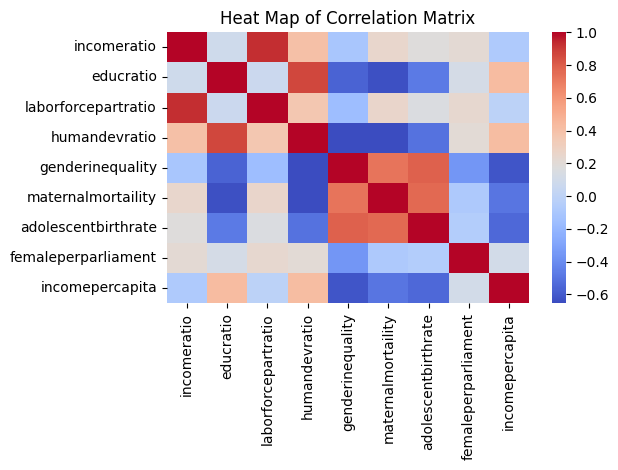

,38,11
meanscore,-0.068,-0.071
kernelpca__gamma,0.120,0.150
kernelpca__kernel,poly,linear
kernelpca__n_components,4,7
randomforestregressor__max_depth,18,11
randomforestregressor__min_samples_leaf,5,7


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import KernelPCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys
sys.path.append(os.getcwd() + "/helperfunctions")
from preprocfunc import OutlierTrans

pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:,.3f}'.format

un_income_gap = pd.read_csv("data/un_income_gap.csv")
un_income_gap.set_index('country', inplace=True)
un_income_gap['incomeratio'] = \
  un_income_gap.femaleincomepercapita / \
    un_income_gap.maleincomepercapita
un_income_gap['educratio'] = \
  un_income_gap.femaleyearseducation / \
     un_income_gap.maleyearseducation
un_income_gap['laborforcepartratio'] = \
  un_income_gap.femalelaborforceparticipation / \
     un_income_gap.malelaborforceparticipation
un_income_gap['humandevratio'] = \
  un_income_gap.femalehumandevelopment / \
     un_income_gap.malehumandevelopment
un_income_gap.dropna(subset=['incomeratio'], inplace=True)

num_cols = ['educratio','laborforcepartratio',
  'humandevratio','genderinequality',
  'maternalmortaility','adolescentbirthrate',
  'femaleperparliament','incomepercapita']

gap_sub = un_income_gap[['incomeratio'] + num_cols]

gap_sub.\
  agg(['count','min','median','max']).T
  
corrmatrix = gap_sub.corr(method="pearson")

sns.heatmap(corrmatrix, xticklabels=corrmatrix.columns,
  yticklabels=corrmatrix.columns, cmap="coolwarm")
plt.title('Heat Map of Correlation Matrix')
plt.tight_layout()
plt.show()
  

# create training and testing DataFrames
X_train, X_test, y_train, y_test =  \
  train_test_split(gap_sub[num_cols],\
  gap_sub[['incomeratio']], test_size=0.2, random_state=0)

# instantiate a pca object and fit the model
kpca = KernelPCA()

rfreg = RandomForestRegressor()

pipe1 = make_pipeline(OutlierTrans(2),
  SimpleImputer(strategy="median"), MinMaxScaler(),
  kpca, rfreg)
 
rfreg_params = {
 'kernelpca__n_components':
    randint(2, 9),
 'kernelpca__gamma':
     np.linspace(0.03, 0.3, 10),
 'kernelpca__kernel':
     ['linear', 'poly', 'rbf', 
      'sigmoid', 'cosine'],
 'randomforestregressor__max_depth':
     randint(2, 20),
 'randomforestregressor__min_samples_leaf':
     randint(5, 11)
}

rs = RandomizedSearchCV(pipe1, rfreg_params,
  cv=4, n_iter=40,
  scoring='neg_mean_absolute_error',
  random_state=1)
rs.fit(X_train, y_train.values.ravel())

rs.best_params_
rs.best_score_

results = \
  pd.DataFrame(rs.cv_results_['mean_test_score'], \
    columns=['meanscore']).\
  join(pd.DataFrame(rs.cv_results_['params']), how="left", on=None, validate="many_to_many").\
  sort_values(['meanscore'], ascending=False)

results.iloc[1:3].T